<center> <h1>Diversification and portfolio optimization</h1> </center>

<center>William Mann</center>

<center>
<img src="https://wgjm1986.github.io/Investments/Emory_small.png" height="200px" width="300px" />
</center>                                                                                            

## Risk and return

The major questions for the rest of the course are:
- How we should define and measure investment risk?
- What kind of return do we have to forecast on an investment, in order for it to be worthwhile given its risk?

These are difficult questions, and we will not claim to “answer” them.

We will simply explore the way people have thought about them.

## The approach of modern portfolio theory (MPT)

1. **What goal is an investor trying to accomplish?** Roughly speaking, maximize the <u>average return</u> on her wealth, minus a penalty for the <u>variance</u> of this return.  

2. **Then, what risky portfolio does she want to hold?** The one with the <u>highest possible Sharpe ratio</u>.  

3. **Then, how will she assess an individual investment?** Based on its <u>alpha</u> (α) compared to her current portfolio. If α > 0, she wants to hold more of it. If α < 0, less.  

4. **Then, how will the <u>average</u> investor think?** The average investor must hold the market portfolio. Then the most natural “equilibrium” is given by the CAPM: All α values are zero, when compared with the market portfolio.

## Useful approximation of geometric mean

- Geometric average return is the true measure of performance, because you can convert it directly to a cumulative return.
    - Geometric average is always less than arithmetic average, except in the special case that the return is constant over time.
    - A high arithmetic average return can be misleading!
- The geometric average return of a portfolio is hard to forecast, but we can apply a useful approximation:

$$
\text{Geometric mean return} \approx \mu - \frac{1}{2}\sigma^2
$$
(textbook formula 5.15)

Here σ is the volatility (standard deviation) of the return.

## Volatility drag

- From $\mu - \frac{1}{2}\sigma^2$ we see that **volatility hurts performance.**
    - This effect is often called “volatility drag” or the “volatility tax”.
- Diversification offers one way to lower the σ of a portfolio, and this can sometimes be worthwhile even if it lowers µ.
- This is true even for a patient and long-term investor!

## Possible investor objectives

A **growth-optimal strategy** seeks to maximize average growth rate, so their "objective function" is
$$
\mu - \frac{1}{2}\sigma^2
$$
This approach is also called the “log-optimal strategy" or the “Kelly criterion.”

A more flexible objective is a *mean-variance utility function,*
$$
\mu - A \frac{1}{2}\sigma^2
$$
where A > 0 is potentially different for every individual.
With $A=1$ this is the growth-optimal strategy from above.

In principle, one could imagine many other objectives as well.

## What we will assume

We will usually only assume that investors are **risk-averse:**  
For a given level of µ, they prefer portfolios with lower σ.
- This assumption was true for both of the objectives above.
- Again, it seems reasonable even for a patient long-term investor.

We will also assume that σ is the investor’s *only* risk measure.
- This may be simplistic, compared to how investors *think*. But it seems to capture most of how they *behave*.
- To be clear, we are assuming that investors measure the risk of their *entire wealth portfolio* only through its volatility. This does not mean that they evaluate individual investments based on volatility. In fact, we will see that they should not.

## µ and σ for a portfolio of two investments

A portfolio’s return is the weighted average of its ingredients’ returns.

For example, with just two investments A and B,
$$ r_{pt} = w_A \times r_{At} + w_B \times r_{Bt} $$

The weights $w_A$ and $w_B$ are the percentage of the portfolio's dollar allocated to A and B.

The portfolio's arithmetic average return µ works in the same way:
$$ \mu_p = w_A \times \mu_A + w_B \times \mu_B $$

The portfolio's return volatility is more complicated (textbook formula 7.7):
$\sigma_p = \sqrt{\sigma_p^2}$, where

$$
\sigma_p^2 = w_A^2 \times \sigma_A^2 + w_B^2 \times \sigma_B^2 + 2 \times w_A \times w_B \times \sigma_{AB}
$$

$$
\sigma_{AB} \equiv \sigma_A \times \sigma_B \times \rho_{AB}
$$

(These formulas all work with either raw returns or excess returns.)

## µ and σ for with many investments

Matrix formulas are cleaner, and work for any number of portfolio ingredients.

Suppose we have $N$ investments and write out their returns as
$$
r_t \equiv \left[\begin{matrix} r_{1t} \\ r_{2t} \\ \vdots \\ r_{Nt} \end{matrix}\right]
\quad , \quad
\mu \equiv \left[\begin{matrix} \mu_1 \\ \mu_2 \\ \vdots \\ \mu_N \end{matrix}\right]
\quad , \quad
\Sigma \equiv \left[\begin{matrix} \sigma_1^2 & \sigma_{12} & \dots & \sigma_{1N} \\ \sigma_{12} & \sigma_2^2 & \dots & \sigma_{2N} \\ \vdots & \vdots & \ddots & \vdots \\ \sigma_{1N} & \sigma_{2N} & \dots & \sigma_N^2 \end{matrix}\right]
$$

If we build a portfolio with weights $w = [w_1,w_2,\dots,w_N]$ then
$$
\mu_p = w' \mu \quad , \quad \sigma_p^2 = w' \Sigma w
$$

You can check that $N=2$ gives the formulas on the previous slide.

I will not test you on these formulas, but will use them at times.

In [1]:
import wrds
import fredapi
import pandas as pd
import math
import numpy as np
import os
pd.options.mode.chained_assignment = None  # default='warn'
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [14.0, 7.0]
import matplotlib.ticker as mtick

conn = wrds.Connection(wrds_username='wmann')

# One-month risk-free rates
FF3F = conn.get_table(library='ff_all',table='factors_monthly')
FF3F['month'] = pd.to_datetime(FF3F['date']).dt.to_period('M')
FF3F = FF3F.drop('date',axis=1).drop('dateff',axis=1).set_index('month')
riskfree = FF3F.rf.astype(float)
riskfree = riskfree['2004':'2023']

# Mutual fund NAVs and distributions from WRDS: We have to merge three different tables, *fund_hdr*, *dividends*, and *monthly_nav*.
# The fund_hdr table tells us, for each ticker, the internal identifier *crsp_fundno* that the database uses for the corresponding fund.
tickers = ('VFINX','FKUTX','FBDIX')
identifiers = conn.raw_sql( "select crsp_fundno, ticker from crsp_q_mutualfunds.fund_hdr " \
	+ "where ticker in " + "('" + "','".join(tickers) + "')").set_index('crsp_fundno')
# The *monthly_nav* table tells us the fund's NAVs at the end of the month (notice we are now looking them up the internal identifier *crsp_fundno*).
NAVs = conn.raw_sql( "select crsp_fundno, caldt, mnav from crsp_q_mutualfunds.monthly_nav " \
	+ "where crsp_fundno in " + "('" + "','".join( str(int(identifier)) for identifier in identifiers.index.values ) + "')")
NAVs['month'] = pd.to_datetime(NAVs['caldt']).dt.to_period('M')
NAVs = NAVs.drop('caldt',axis=1).set_index(['crsp_fundno','month'])
# The *dividends* table tells us the distributions that each fund paid in each month.
dividends = conn.raw_sql( "select crsp_fundno, caldt, dis_amt from crsp_q_mutualfunds.dividends " \
	+ "where crsp_fundno in " + "('" + "','".join( str(int(identifier)) for identifier in identifiers.index.values) + "')") 
dividends['month'] = pd.to_datetime(dividends['caldt']).dt.to_period('M')
dividends = dividends.drop('caldt',axis=1).set_index(['crsp_fundno','month'])
dividends = dividends.groupby(['crsp_fundno','month']).sum()
# Join the three mutual fund tables (identifiers, NAVs, dividends) and format the data as desired
Funds = identifiers.join( NAVs.join(dividends) ) 
# Drop the internal fund identifier that CRSP uses,
# reset the dataframe to index by ticker instead
Funds = Funds.reset_index().drop('crsp_fundno',axis=1).set_index(['ticker','month'])
# Dividends are recorded as NaN in any month between dividend dates,
# so replace these with zero using the fillna function
Funds['dis_amt'] = Funds['dis_amt'].fillna(0)
# Convert the Funds dataframe to a dictionary, which will be easier to loop over
Funds = {ticker: Funds.loc[ticker] for ticker in tickers}
# Keep just the dates I want
Funds = {ticker: fund['12-2003':'2023'] for ticker,fund in Funds.items()}

Loading library list...
Done


In [2]:
# Uncomment this block to save to Excel if desired

try: os.remove("Homework 1 example.xlsx")
except OSError: pass

# set up custom ExcelWriter engine to get the date format correct in the output file
writer = pd.ExcelWriter('Homework 1 example.xlsx', engine='xlsxwriter', datetime_format= "yyyy-mm")

riskfree.to_excel(writer,sheet_name="Risk-free")

for ticker in tickers:
    Funds[ticker].to_excel(writer,sheet_name=ticker)

writer.close()

In [3]:
# Calculate returns
Returns = {ticker: (fund.mnav + fund.dis_amt)/fund.mnav.shift() - 1 for ticker,fund in Funds.items()}
# Calculate excess returns
Excess_Returns = {ticker: fund - riskfree for ticker,fund in Returns.items()}
# Drop missing return observation in the first month for each fund
Excess_Returns = {ticker: fund.dropna() for ticker,fund in Excess_Returns.items()}

In [4]:
# Generic function for the figures I want to include in the slides
def base_figure(fig,ax):
    plt.scatter(0,0,color='blue',s=15)
    plt.annotate('Rf',[0.001,0.0002])
    for ticker,fund in Excess_Returns.items():
        plt.scatter(fund.std(),fund.mean(),color='blue',s=15)
        plt.annotate(ticker,[fund.std()+.0005,fund.mean()+.0001])
    plt.xlim(-0.01,0.07)
    plt.ylim(-.001,0.01)
    plt.xlabel("Volatility of portfolio excess return")
    plt.ylabel("Average portfolio excess return")
    plt.axhline(0,color='lightgrey',zorder=0)
    plt.axvline(0,color='lightgrey',zorder=0)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

## Finding the optimal risky portfolio.

Suppose the investor has just three of the funds from HW1, plus a risk-free investment.  
Let's plot the average and volatility of excess returns of each available investment.

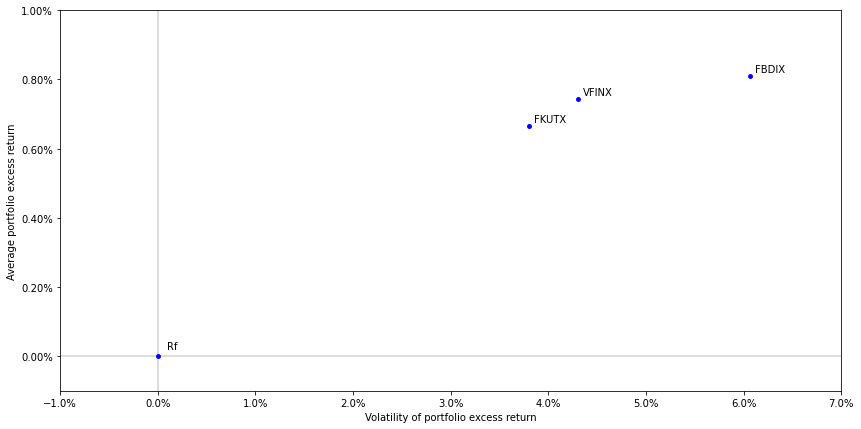

In [5]:
fig,ax = plt.subplots()
base_figure( fig, ax )

## Allocation between risk-free and risky

We separate the investor’s decision into two questions:
- Which portfolio of risky investments to hold?
- How much to invest in it, and how much to save risk-free?

To understand the first question, we think ahead to the second.

- Suppose an investor allocates weight w to a risky portfolio p,  
that has average excess return $\mu_p$ with volatility $\sigma_p$,  
and allocates the rest $1-w$ to the risk-free investment.
- A risk-free investment has zero excess return and volatility.  
That makes the earlier formulas much simpler:  
The average excess return is $w \times \mu_p$, with volatility $w \times \sigma_p$.
In the figure, different choices of $w$ trace out a straight line.

## Allocation between risk-free and VFINX

In [6]:
%%capture
VFINX_figure,ax = plt.subplots()
base_figure(VFINX_figure, ax)
plt.plot([0,1.5*Excess_Returns['VFINX'].std()],[0,1.5*Excess_Returns['VFINX'].mean()],color='red',zorder=0);

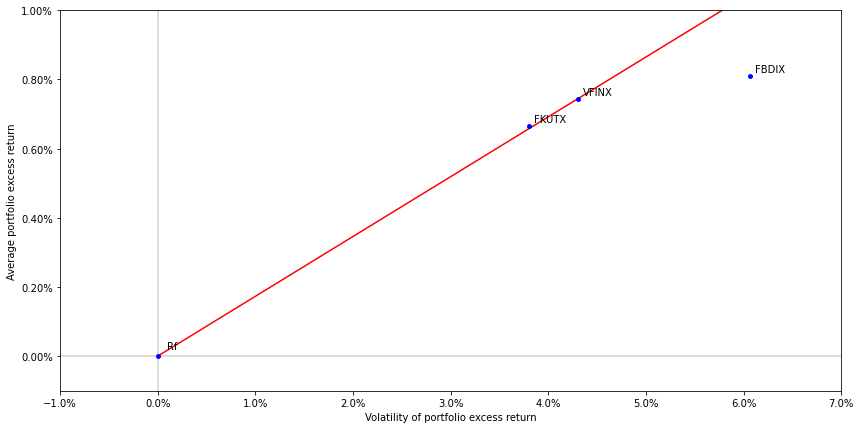

In [7]:
VFINX_figure

## Allocation between risk-free and FBDIX

In [8]:
%%capture
FBDIX_figure,ax = plt.subplots()
base_figure(FBDIX_figure,ax)
plt.plot([0,1.5*Excess_Returns['FBDIX'].std()],[0,1.5*Excess_Returns['FBDIX'].mean()],color='red',zorder=0);

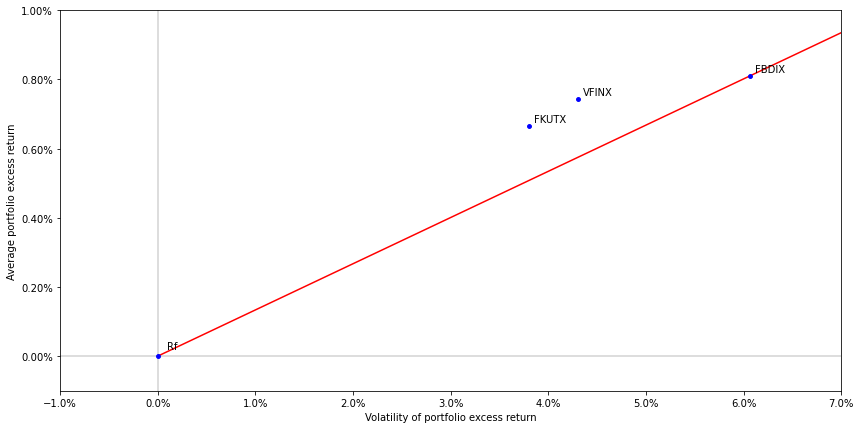

In [9]:
FBDIX_figure

## Allocation between risk-free and FKUTX

In [10]:
%%capture
FKUTX_figure,ax = plt.subplots()
base_figure(FKUTX_figure,ax)
plt.plot([0,1.5*Excess_Returns['FKUTX'].std()],[0,1.5*Excess_Returns['FKUTX'].mean()],color='red',zorder=0);

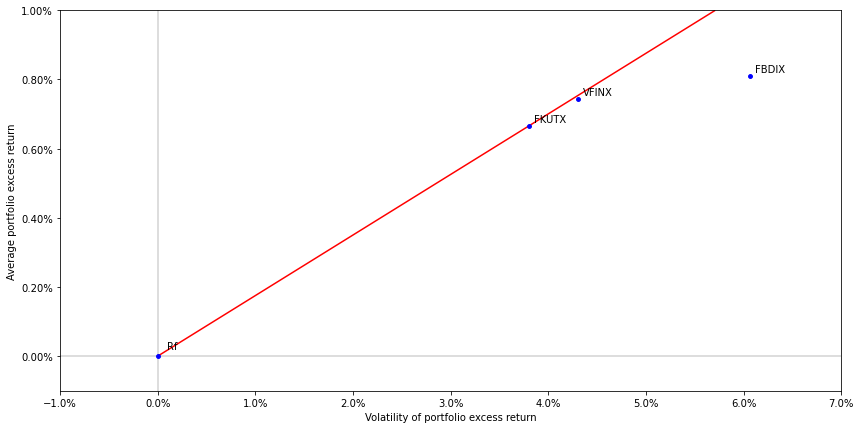

In [11]:
FKUTX_figure

### The investor wants the highest possible Sharpe ratio

- In the figure, a straight line from the risk-free investment to any risky investment is called a **capital allocation line (CAL).**
- Along the line, there is a tradeoff between σ and µ. The steeper is the line, the better is the reward (higher µ) that we get for accepting higher volatility (higher σ).
- The exact formula for the line is 
$$
\mu_{\text{portfolio}} = \frac{\mu_{\text{risky}}}{\sigma_{\text{risky}}} \times \sigma_{\text{portfolio}}
$$
This is the average return we can get for any choice of volatility.
- Notice that $\frac{\mu_{\text{risky}}}{\sigma_{\text{risky}}}$ is exactly the Sharpe ratio of the risky investment. So the investor wants to find the risky investment with <u>the highest Sharpe ratio</u> (the steepest CAL).
- This means that if they had to choose <u>one</u> fund, they would choose FKUTX.

## But what is the highest possible Sharpe ratio?

- To repeat carefully the above conclusion: FKUTX would be the best of the three funds, if the investor had to allocate their non-risk-free investing <u>entirely to one of them.</u>
- But of course the investor doesn’t have to do that. They are free to allocate their money across all three funds.
- And it turns out that this might attain a higher Sharpe ratio than any of the three funds attains on its own.
- For example, suppose the investor allocates their risky investing to a portfolio that is 60\% FKUTX, 20\% VFINX, 20\% FBDIX...

### Allocations between risk-free and a 60/20/20 portfolio

In [12]:
%%capture
superior_allocation_figure,ax = plt.subplots()
base_figure(superior_allocation_figure,ax)
high_SR_weights = np.array([0.2,0.6,0.2])
high_SR_mu =  high_SR_weights @ [fund.mean() for ticker,fund in Excess_Returns.items()]
high_SR_vol = np.sqrt( high_SR_weights @ ( np.cov([fund for ticker,fund in Excess_Returns.items()]) @ high_SR_weights ) )
plt.scatter(high_SR_vol,high_SR_mu,color='red',s=15)
plt.plot([0,1.5*high_SR_vol],[0,1.5*high_SR_mu],color='red',zorder=0)

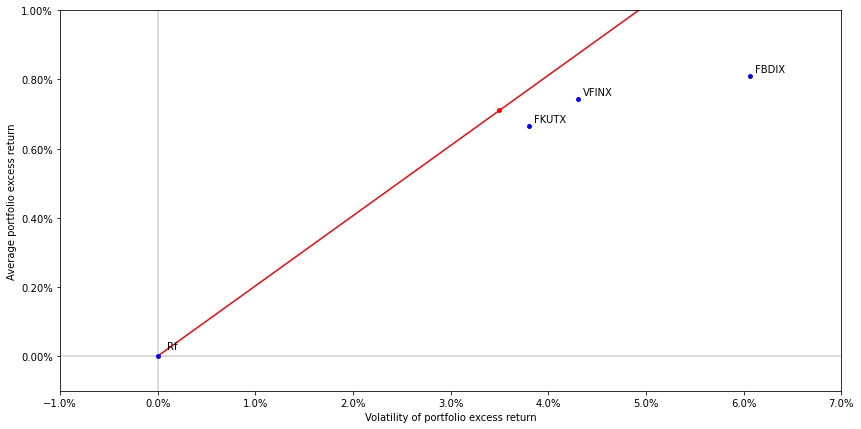

In [13]:
superior_allocation_figure

### How can the Sharpe ratio be higher for the portfolio than for any individual investment?

Math reasoning: Because volatilities do not average like returns.
- Imagine any portfolio you could form of the three funds.
- Unlike the average return, the volatility of the portfolio is not just a simple average of the individual funds’ volatilities. In fact it is always less than that average.
- When σ falls faster than µ, the ratio µ/σ increases.

Economic reasoning: Diversification.
- The funds’ returns are all risky, but not perfectly correlated.
- When combined together, the correlations partially offset, giving us average returns at below-average volatility.
- Harry Markowitz called this “the only free lunch in investing.”

## Illustrating diversification: Perfect positive correlation

Suppose two investments have perfect positive correlation, $\rho_{AB}=1$.

In this extreme case, portfolio volatility *is* just a weighted average.

To see this, substitute $\rho=1$ into formula (7.7) and simplify:
$$
\sigma_p^2 = (w_A \sigma_A + w_B \sigma_B)^2
$$

When we take the square root of both sides,
$$
\sigma_p = w_A \sigma_A + w_B \sigma_B
$$

## Illustrating diversification: Zero correlation

Suppose two investments have zero correlation, $\rho_{AB}=0$.
Then formula (7.7) becomes:

$$
\sigma_p^2 = w_A^2 \sigma_A^2 + w_B^2 \sigma_B^2
$$

When we take the square root of both sides,
$$
\sigma_p = \sqrt{ w_A^2 \sigma_A^2 + w_B^2 \sigma_B^2 }
$$

This is *less* than the weighted average $w_A \times \sigma_A + w_B \times \sigma_B$.

In general, volatility is less than a weighted average whenever ρ < 1.
This effect gets more powerful as ρ gets smaller.

Visually, it causes the curves in the figures to bend leftward.

## Figure 7.6: Two risky investments in a portfolio

The solid black line traces out possible σ and µ values when $\rho_{AB}=1$.  
The dashed blue line traces out possible σ and µ values when $\rho_{AB}=0$.

<center>
<img src="https://wgjm1986.github.io/Investments/Module%202/Week%206%20-%20Diversification%20and%20portfolio%20optimization/Fig7_6.png" width="500px" />
</center>

## Possible portfolios using just two of the funds

In our data, the correlation between FKUTX and FBDIX is about 0.24.

In [14]:
%%capture
FKUTX_FBDIX_figure,ax = plt.subplots()
base_figure(FKUTX_FBDIX_figure,ax)
mu = [Excess_Returns['FKUTX'].mean(), Excess_Returns['FBDIX'].mean()]
Sigma = np.cov([Excess_Returns['FKUTX'],Excess_Returns['FBDIX']])
for FKUTX_weight in np.linspace(0,1,101):
    weights = np.array([FKUTX_weight, 1-FKUTX_weight])
    portfolio_avg = weights @ mu
    portfolio_vol = np.sqrt( weights @ (Sigma @ weights) )
    plt.scatter(portfolio_vol,portfolio_avg,color='lightsteelblue',s=10,zorder=0)

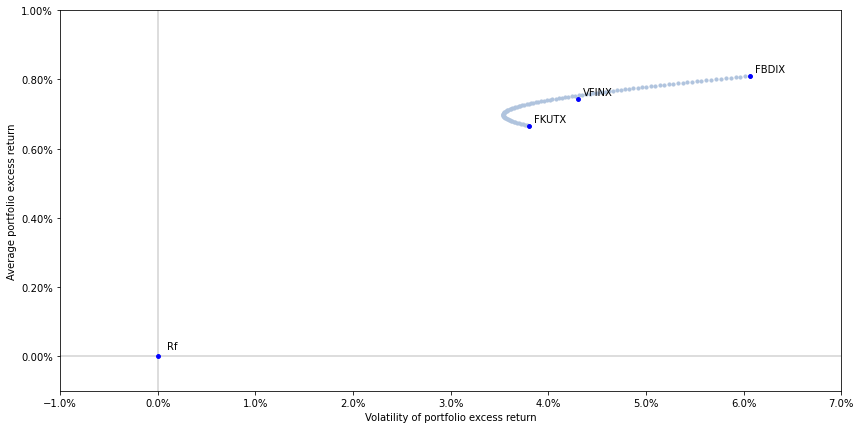

In [15]:
FKUTX_FBDIX_figure

## Steepest CAL using just two of the three funds

This is the steepest CAL we can find using just FKUTX and FBDIX:

In [16]:
mu = [ Excess_Returns['FKUTX'].mean() , Excess_Returns['FBDIX'].mean() ]
Sigma = np.cov([ Excess_Returns['FKUTX'], Excess_Returns['FBDIX'] ])

optimal_weights_unscaled = np.linalg.inv(Sigma) @ mu
optimal_weights = optimal_weights_unscaled / sum(optimal_weights_unscaled)

optimal_SR = (optimal_weights @ mu) / np.sqrt( optimal_weights @ (Sigma @ optimal_weights) )

print("Optimal weights: " + '%4.2f' % (100*optimal_weights[0]) + "% on FKUTX, "
     + '%4.2f' % (100*optimal_weights[1]) + "% on FBDIX")
print("Sharpe ratio achieved: " + '%5.4f' % optimal_SR)

Optimal weights: 71.46% on FKUTX, 28.54% on FBDIX
Sharpe ratio achieved: 0.1986


In [17]:
%%capture
FKUTX_FBDIX_CAL_figure,ax = plt.subplots()
base_figure( FKUTX_FBDIX_CAL_figure,ax )

mu_grid = [ optimal_weights @ mu ]
v_grid = [ np.sqrt( optimal_weights @ (Sigma @ optimal_weights ) ) ]

for i in np.linspace(0,1,101):
    weights = np.array([i,1-i])
    mu_grid.append(weights @ mu)
    v_grid.append( np.sqrt( weights @ (Sigma @ weights) ) )
Figure = plt.scatter(v_grid,mu_grid,color='lightsteelblue',s=10,zorder=0)
plt.scatter(v_grid[0],mu_grid[0],color='red',s=15)
plt.plot([0, v_grid[0], 1.5*v_grid[0] ] , [0, mu_grid[0], 1.5*mu_grid[0]], color='red');

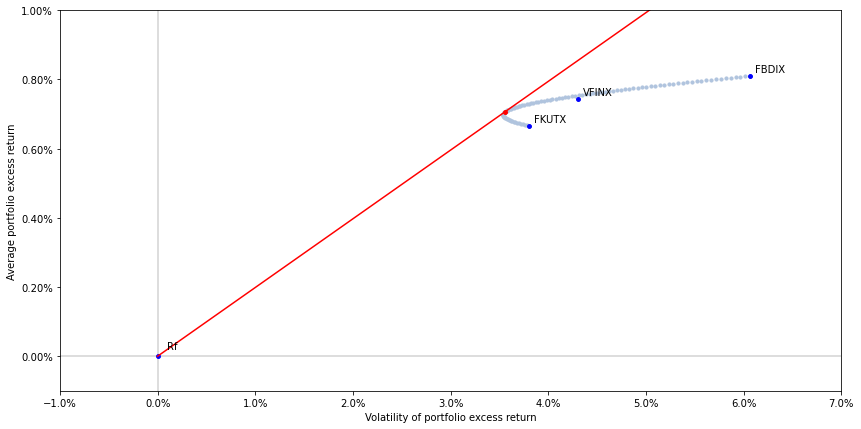

In [18]:
FKUTX_FBDIX_CAL_figure

## Figure 7.10: Many risky investments in a portfolio

<center>
<img src="https://wgjm1986.github.io/Investments/Module%202/Week%206%20-%20Diversification%20and%20portfolio%20optimization/Fig7_10.png" height="800px" />
</center>

## Possible portfolios using all three funds

In [19]:
%%capture
all_funds_figure,ax = plt.subplots()
base_figure( all_funds_figure,ax )

mu_grid = []
v_grid = []

mu = [fund.mean() for ticker,fund in Excess_Returns.items()]
Sigma = np.cov([fund for ticker,fund in Excess_Returns.items()])

for i in np.linspace(-0.1,1.1,101):
    for j in np.linspace(-0.1,1.1,101):
        weights = np.array([i,j,1-i-j])
        mu_grid.append(weights @ mu)
        v_grid.append( np.sqrt( weights @ (Sigma @ weights) ) )
Figure = plt.scatter(v_grid,mu_grid,color='lightsteelblue',s=1,zorder=0)

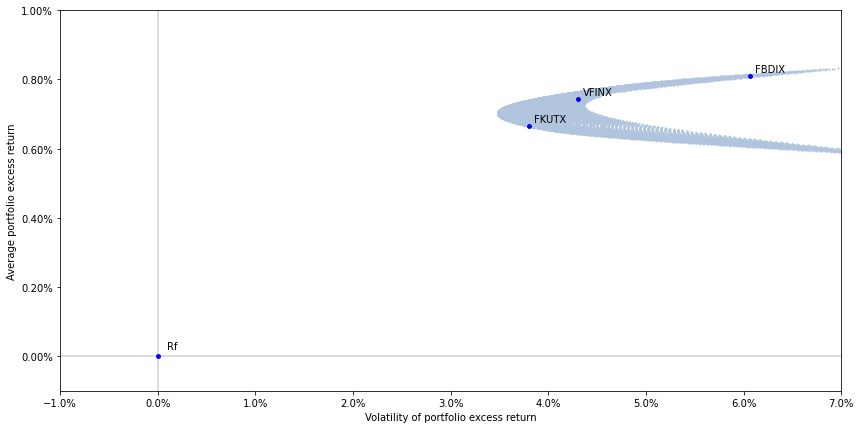

In [20]:
all_funds_figure

## Portfolio with the highest SR, steepest CAL

In [21]:
%%capture
mu = [fund.mean() for ticker,fund in Excess_Returns.items()]
Sigma = np.cov([fund for ticker,fund in Excess_Returns.items()])
optimal_weights_unscaled = np.linalg.inv( Sigma ) @ mu
optimal_weights = optimal_weights_unscaled / sum(optimal_weights_unscaled)

(optimal_weights @ mu) / np.sqrt( optimal_weights @ (Sigma @ optimal_weights ) )

all_funds_figure,ax = plt.subplots()
base_figure(all_funds_figure,ax)

mu_grid = [ optimal_weights @ mu ]
v_grid = [ np.sqrt( optimal_weights @ (Sigma @ optimal_weights ) ) ]

mu = [fund.mean() for ticker,fund in Excess_Returns.items()]
Sigma = np.cov([fund for ticker,fund in Excess_Returns.items()])

for i in np.linspace(-0.1,1.1,101):
    for j in np.linspace(-0.1,1.1,101):
        weights = np.array([i,j,1-i-j])
        mu_grid.append(weights @ mu)
        v_grid.append( np.sqrt( weights @ (Sigma @ weights) ) )
plt.scatter(v_grid,mu_grid,color='lightsteelblue',s=1,zorder=0)
plt.scatter(v_grid[0],mu_grid[0],color='red',s=15)
plt.plot([0, v_grid[0], 1.5*v_grid[0] ] , [0, mu_grid[0], 1.5*mu_grid[0]], color='red');

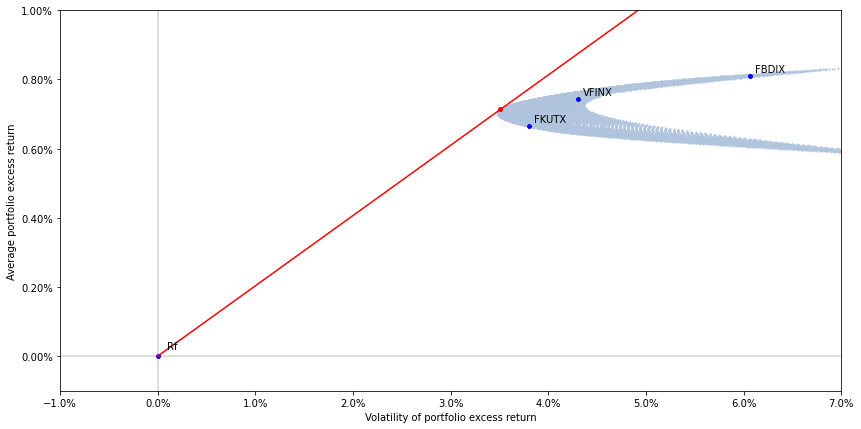

In [22]:
all_funds_figure

In [23]:
print("The weights in the previous figure are roughly "
      f"{100*optimal_weights[0]:.2f}% VFINX, "
      f"{100*optimal_weights[1]:.2f}% FKUTX, "
      f"{100*optimal_weights[2]:.2f}% FBDIX.")

The weights in the previous figure are roughly 25.59% VFINX, 55.62% FKUTX, 18.78% FBDIX.


### How to find the portfolio with the highest Sharpe ratio?

Some possible approaches are as follows:

- Manual trial-and-error: Create a large list of portfolio weights.
Calculate each Sharpe ratio and select the highest one.

- Automated: Use an optimizer to search out the best weights.
This is logically similar to the trial-and-error approach, but obviously faster and more reliable.

- Explicit formula: Calculate a set of unscaled weights equal to $\Sigma^{-1}\mu$. Then divide each weight by their sum, so they add up to 100%. (With just two assets, this is textbook formula 7.13.)

We will see more approaches next week.

### Constraints on the allowable portfolio: 

The formula $\Sigma^{-1}\mu$ places no constraints on the positions you are willing to take. It assumes you are willing to engage in heavy short-selling, or very lopsided allocations across investment categories, if that is the answer that comes out of the problem. 

In practice you often want to impose some kind of constraint on the portfolio you are willing to accept, such as avoiding short sales, not allocating too heavily to small-cap stocks, etc.

In some cases there may be a modified version of the above formula that can capture these constraints, but typically not. Instead, you will almost always resort to the "optimization" approach from the prior slide. 

Fortunately it is straightforward to add constraints into the optimization. However, we probably won't have time to show any examples of this.

In [24]:
# Let's pull back up our answer from the two-investment example so we can finish that case.

mu = [ Excess_Returns['FKUTX'].mean() , Excess_Returns['FBDIX'].mean() ]
Sigma = np.cov([ Excess_Returns['FKUTX'], Excess_Returns['FBDIX'] ])

optimal_weights_unscaled = np.linalg.inv(Sigma) @ mu
optimal_weights = optimal_weights_unscaled / sum(optimal_weights_unscaled)

optimal_SR = (optimal_weights @ mu) / np.sqrt( optimal_weights @ (Sigma @ optimal_weights) )

### Finishing the two-investment example: Find the investor's optimal risky allocation

We have found the risky portfolio with the highest Sharpe ratio. Now, let's complete the problem by figuring out how much the investor will allocate to that portfolio vs risk-free saving.

To answer this question, we must make some kind of assumption about how the investor trades off risk and return. 

To put some numbers on it, imagine a specific utility function that takes a measure of risk and return and gives us a score, and then choose the portfolio with the highest score.

Of course things aren't so mechanical in real life. You can imagine this standing in for a more holistic conversation with a financial advisor.

### Optimal allocation to risky portfolio with mean-variance utility

Specifically, suppose the investor has mean-variance utility.

Remember, this means they rank portfolios according to how they score in the formula:
$$
µ - \frac{1}{2} A \sigma^2
$$
where A is a number that is chosen to measure their risk aversion. 

So we reward portfolios for having higher (arithemetic) average return, and penalize them for having more volatility. Remember this is motivated by the fact that $A=1$ would be maximizing the average (geometric) rate of return.

Let's suppose that $A=8$ and finish the example we've been doing.

### Finding the optimal allocation to risky portfolio

Trial and error approach 1: Just list out possible portfolios and search on a grid.

We make a list of possible weights $w$. Then for each weight, we will calculate the average excess return $\mu = w \mu_{\text{risky}}$ and volatility $\sigma = w \sigma_{\text{risky}}$ of a portfolio with weight $w$ on the risky portfolio and the rest on risk-free. Finally we calculate the utility of each portfolio based on mean-variance utility $\mu - \frac{1}{2}A \sigma^2$ with $A=8$. And then we just select the portfolio with the highest score.

First we create the weights and calculate the $\mu$, $\sigma$, and utility for each weight:

In [25]:
weights = pd.Series( np.linspace(0,1,51) )
mu_list = weights*(optimal_weights @ mu)
sigma_list = weights*np.sqrt(optimal_weights @ Sigma @ optimal_weights )
A = 8
utilities = mu_list - 0.5*A*(sigma_list**2)

Then combine them into a table, and find and print the row with highest utility:

In [26]:
portfolios = pd.concat(
    [weights,1-weights,mu_list,sigma_list,utilities],axis=1
)
portfolios.columns = ["Weight on risky",
                      "Weight on risk-free",
                      "Avg excess return",
                      "Vol of excess return",
                      "Utility"]
print("The row with the highest utility score looks as follows:")
print( portfolios.loc[ portfolios['Utility'].idxmax() ] )

The row with the highest utility score looks as follows:
Weight on risky         0.700000
Weight on risk-free     0.300000
Avg excess return       0.004951
Vol of excess return    0.024930
Utility                 0.002465
Name: 35, dtype: float64


Here are the surrounding rows in the table. 

The code just above told us that the max utility is in row 35.

In [27]:
portfolios[30:40]

,Weight on risky,Weight on risk-free,Avg excess return,Vol of excess return,Utility
30,0.60,0.40,0.004244,0.021369,0.002417
31,0.62,0.38,0.004385,0.022081,0.002435
32,0.64,0.36,0.004527,0.022793,0.002449
33,0.66,0.34,0.004668,0.023505,0.002458
34,0.68,0.32,0.004810,0.024218,0.002464
35,0.70,0.30,0.004951,0.024930,0.002465
36,0.72,0.28,0.005092,0.025642,0.002462
37,0.74,0.26,0.005234,0.026355,0.002456
38,0.76,0.24,0.005375,0.027067,0.002445
39,0.78,0.22,0.005517,0.027779,0.002430


### Shortcut: Formula for the optimal allocation the risky portfolio

There is a formula to shortcut the above process and give us the exact answer.

When the investor has mean-variance utility, the ideal percent of their wealth to allocate to the risky portfolio is given by:
$$
\frac{ \mathbb{E}[r_p] - r_f }{ A \sigma_p^2 }
$$
(textbook formula 7.14.)

The remaining percentage would be allocated to the risk-free investment.

(To derive this formula, just take the derivative of $(w \mu) - \frac{1}{2} A (w \sigma)^2$ with respect to $w$ and set it equal to zero.)

Applying the formula just above to our problem:

In [28]:
A=8
optimal_allocation = (
    (optimal_weights @ mu) 
    / 
    (A * (optimal_weights @ Sigma @ optimal_weights))
)
print(f"Optimal percentage allocated to risky: {100*optimal_allocation :.2f}%")

Optimal percentage allocated to risky: 69.70%


## Summary: Portfolio optimization procedure

To summarize, we find the investor’s optimal portfolio in two steps:

- First, find the portfolio of risky investments with the highest Sharpe ratio.
    - Visually, this means finding and draw the steepest possible CAL.
    - <u>This step is the same for all investors.</u>
- Second, allocate between this portfolio and the risk-free return.
    - Visually, this means finding the preferred location on the CAL.
    - This step depends on the individual investor (specifically, on their risk aversion, which is measured with the number A in a mean-variance utility function).

The entire process is known as *portfolio optimization.*

## Separation property

The prior slide suggests we could satisfy every investor’s goals,
regardless of their risk attitudes, with just two large mutual funds:

- a money-market fund offering a risk-free rate of return,
- a risky fund with the highest possible Sharpe ratio.

Each investor would choose their preferred location on the CAL,
by allocating different shares of their wealth to the risky fund.

This is called the *separation property* of portfolio optimization,
and is sometimes also called the *two-fund separation theorem.*